In [4]:
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy


from precip_model_functions import *
from precip_extremes_scaling import saturation_thermodynamics, moist_adiabatic_lapse_rate, pars
from smith_lm import full_linear_model_saturated

In [22]:
from scipy.ndimage import gaussian_filter
orog1000 = 1*(xr.apply_ufunc(gaussian_filter,orog.isel(time=0),kwargs={"sigma":1.})>1000.)

In [26]:
def mse_BL(ds,lonlat):
    Lv = 2257e3 #latent heat of vaporization of water, 100°C, in J/kg
    cp = 1e3 #specific heat at constant pressure of air, 100°C, in J/K/kg
    
    gz_surf = 9.81*250+xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
    temp_2m = retrieve_era5_sfc(ds,lonlat,'128_167_2t')   
    
    ps = retrieve_era5_sfc(ds,lonlat,'128_134_sp')
    q = retrieve_era5_pl(ds,lonlat,'128_133_q',firstlev=21,levdisc=1)
    q_surf = q.sel(level=ps/100,method="nearest",drop=True) 
    
    return gz_surf+cp*temp_2m+Lv*q_surf

def mse_plev(ds,lonlat,lev):
    Lv = 2257e3 #latent heat of vaporization of water, 100°C, in J/kg
    cp = 1e3 #specific heat at constant pressure of air, 100°C, in J/K/kg
    
    gz = retrieve_era5_pl(ds,lonlat,'128_129_z',firstlev=14,levdisc=1)
    gz_700 = gz.sel(level=lev,method="nearest",drop=True)
    
    temp = retrieve_era5_pl(ds,lonlat,'128_130_t',firstlev=14,levdisc=1)
    temp_700 = temp.sel(level=lev,method="nearest",drop=True)
    
    q = retrieve_era5_pl(ds,lonlat,'128_133_q',firstlev=14,levdisc=1)
    q_700 = q.sel(level=lev,method="nearest",drop=True)
    
    return gz_700+cp*temp_700+Lv*q_700 

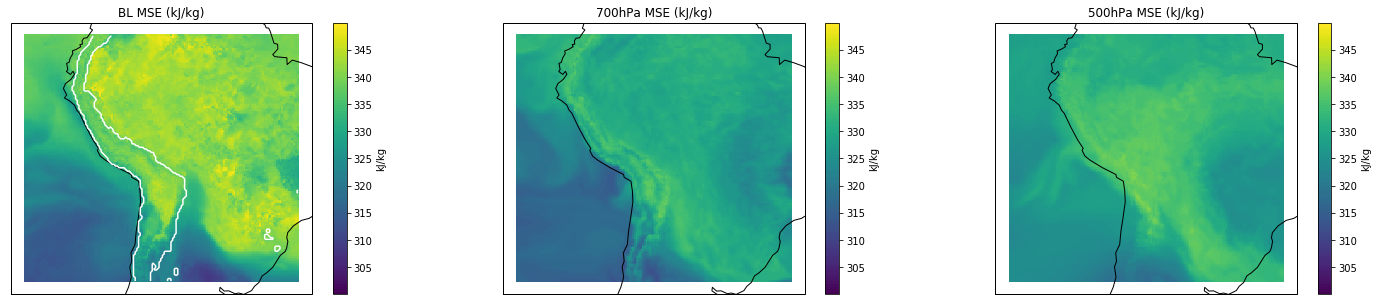

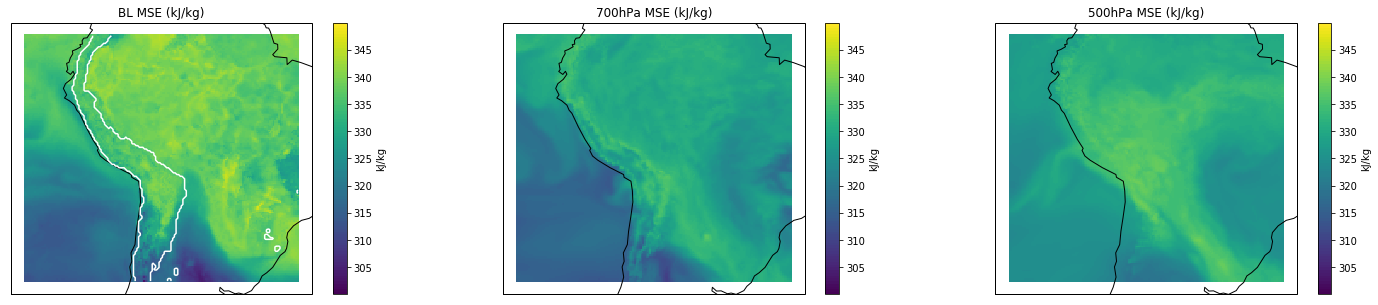

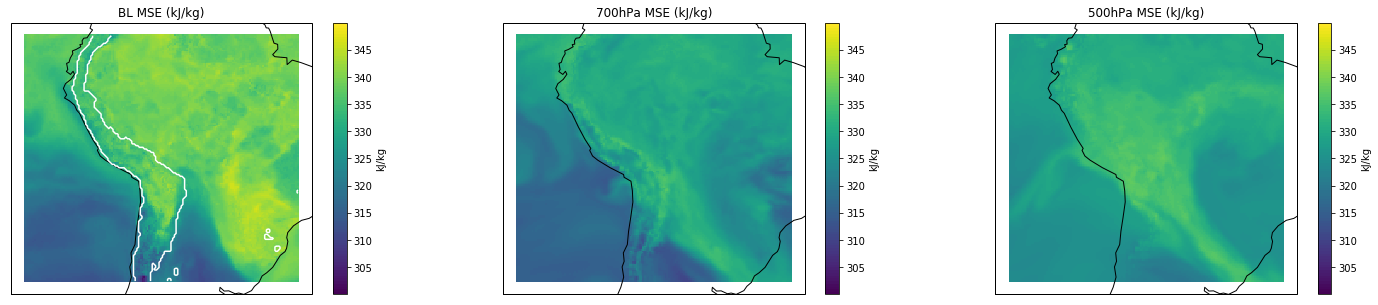

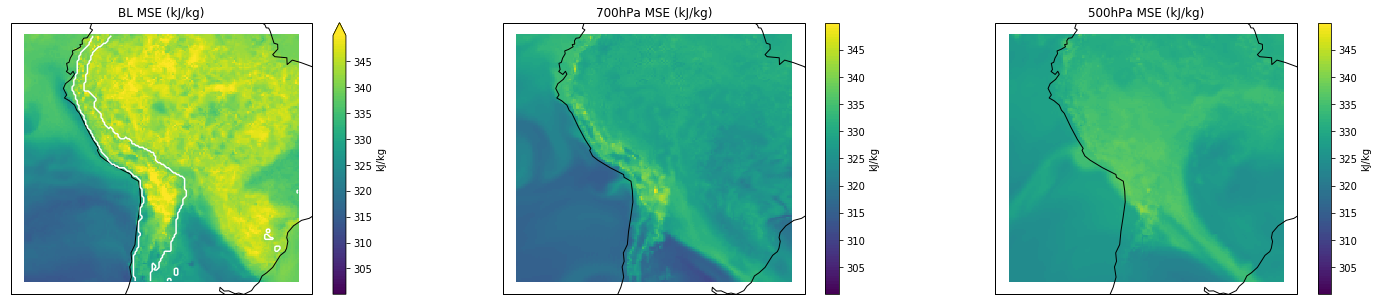

In [28]:
ct="Candes"

lonlat=box[ct]["medium"]
orog1000_box = orog1000.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
mse_B = mse_BL(p99_era5[ct][10:11],box[ct]["medium"])/1e3
mse_700 = mse_plev(p99_era5[ct][10:11],box[ct]["medium"],700)/1e3
mse_500 = mse_plev(p99_era5[ct][10:11],box[ct]["medium"],500)/1e3

for i in range(4):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,5),subplot_kw={'projection': ccrs.PlateCarree()})
    mse_B.isel(time=i).plot( ax=ax1,transform=ccrs.PlateCarree(), cbar_kwargs={"label":"kJ/kg","ticks":np.arange(305.,350.,5.)},levels=np.linspace(300.,350.,100))
    mse_700.isel(time=i).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"kJ/kg","ticks":np.arange(305.,350.,5.)},levels=np.linspace(300.,350.,100))
    mse_500.isel(time=i).plot(ax=ax3,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"kJ/kg","ticks":np.arange(305.,350.,5.)},levels=np.linspace(300.,350.,100))
        
    kw = {'levels':[0.5], 'colors':['w']}
    orog1000_box.plot.contour(ax=ax1,transform=ccrs.PlateCarree(),**kw)
    
    ax1.coastlines();ax2.coastlines();ax3.coastlines()
    ax1.set_title("BL MSE (kJ/kg)");ax2.set_title("700hPa MSE (kJ/kg)");ax3.set_title("500hPa MSE (kJ/kg)")
    
#mse_B